# Make predictions with the deployment

## Setup

### Import libraries

In [1]:
import datetime
from datetime import timedelta
from importlib import reload
from os.path import join
import time

import datarobot as dr
import helper
import matplotlib
import numpy as np
import pandas as pd

reload(helper)

<module 'helper' from '/Users/daniel.straulino/Documents/Coding/VolumePrediction/helper.py'>

### Retrieve and prepare data

In [2]:
data = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/trading_activity/stock_data.csv"
)

In [3]:
data = data[
    [
        "date",
        "date_time",
        "Symbol",
        "minute",
        "TradeVolume",
        "TradePrice",
        "NumTrades",
        "Sector",
        "Security_Type",
        "Cap",
        "Style",
        "Exchange",
    ]
].copy()

In [4]:
end = data.date.max()

Make sure that the prediction data has the same formatting as the training data. Use the same modeling settings from previous steps.

In [5]:
# Number of minutes in each window
window_length = 1
# How many windows to look ahead/behind
neighbours_radius = 1
# Use percentage of volume
percentage = True

modelling_choice = {
    "window_length": window_length,
    "window_radius": neighbours_radius,
    "percentage": percentage,
}

In [6]:
aggregation_dictionary = {
    "date": "first",
    "minute": "min",
    "TradeVolume": ["sum", "min", "max", "std"],
    "TradePrice": ["mean", "min", "max", "std"],
    "NumTrades": ["sum", "min", "max", "std"],
}

In [7]:
prediction_data = helper.prepare_data_for_predictions(
    data, modelling_choice, aggregation_dictionary=aggregation_dictionary
)

The next couple of cells should be deleted, because this example only looks at the last 30 minutes.

In [8]:
time_cut = timedelta(hours=15, minutes=30)

In [9]:
prediction_data = prediction_data[prediction_data.minute_min > time_cut]

In [10]:
prediction_data.columns

Index(['date_time_', 'Symbol_', 'Sector_', 'Security_Type_', 'Cap_', 'Style_',
       'Exchange_', 'date_first', 'minute_min', 'TradeVolume_min',
       'TradeVolume_max', 'TradeVolume_std', 'TradePrice_mean',
       'TradePrice_min', 'TradePrice_max', 'TradePrice_std', 'NumTrades_sum',
       'NumTrades_min', 'NumTrades_max', 'NumTrades_std', 'TradeVolume_sum',
       'TradeVolume_min_fwd_1', 'TradeVolume_max_fwd_1',
       'TradeVolume_std_fwd_1', 'TradePrice_mean_fwd_1',
       'TradePrice_min_fwd_1', 'TradePrice_max_fwd_1', 'TradePrice_std_fwd_1',
       'NumTrades_sum_fwd_1', 'NumTrades_min_fwd_1', 'NumTrades_max_fwd_1',
       'NumTrades_std_fwd_1', 'TradeVolume_sum_fwd_1', 'TradeVolume_min_bwd_1',
       'TradeVolume_max_bwd_1', 'TradeVolume_std_bwd_1',
       'TradePrice_mean_bwd_1', 'TradePrice_min_bwd_1', 'TradePrice_max_bwd_1',
       'TradePrice_std_bwd_1', 'NumTrades_sum_bwd_1', 'NumTrades_min_bwd_1',
       'NumTrades_max_bwd_1', 'NumTrades_std_bwd_1', 'TradeVolume_sum_bw

In [11]:
prediction_data[
    [
        "date_first",
        "date_time_",
        "Symbol_",
        "minute_min",
        "TradeVolume_sum",
        "Sector_",
        "Security_Type_",
        "Cap_",
        "Style_",
        "Exchange_",
    ]
].tail()

,date_first,date_time_,Symbol_,minute_min,TradeVolume_sum,Sector_,Security_Type_,Cap_,Style_,Exchange_
148565,2018-06-08,2018-06-08 15:55:00,WMT,0 days 15:55:00,,Retail,Common Stock,Large,Value,NYSE
148566,2018-06-08,2018-06-08 15:56:00,WMT,0 days 15:56:00,,Retail,Common Stock,Large,Value,NYSE
148567,2018-06-08,2018-06-08 15:57:00,WMT,0 days 15:57:00,,Retail,Common Stock,Large,Value,NYSE
148568,2018-06-08,2018-06-08 15:58:00,WMT,0 days 15:58:00,,Retail,Common Stock,Large,Value,NYSE
148569,2018-06-08,2018-06-08 15:59:00,WMT,0 days 15:59:00,,Retail,Common Stock,Large,Value,NYSE


Notice that the rows for which you want predictions need to have all the known in advance features, but not the value to predict.

### Retrieve relevant projects

In [12]:
projects_df = pd.read_pickle("results/VolPred_percentage_each_1min_v_2022-11-14-23-12-28.pkl")

In [13]:
projects_df.head()

,project_id,slice,url,project,deployment_id,MASE,model
0,6372796b52dd086a82a4337c,15:31,https://app.datarobot.com/projects/6372796b52d...,Project(VolPred_percentage_each_1min_15:31_v_2...,6372cd615a87f42014e78ea4,0.77930,63727b232bfd63533d45ffb5
1,63727a1552dd086a82a43383,15:32,https://app.datarobot.com/projects/63727a1552d...,Project(VolPred_percentage_each_1min_15:32_v_2...,6372cd669221ba89ab1c2080,0.75075,63727bc1fdd002317cba0f19
2,63727abc9ae8e86e8b8942e4,15:33,https://app.datarobot.com/projects/63727abc9ae...,Project(VolPred_percentage_each_1min_15:33_v_2...,6372cd6b5a87f42014e78ebe,0.73442,63727c9d98110b63f2cc1e55
3,63727b6b9ae8e86e8b8942ff,15:34,https://app.datarobot.com/projects/63727b6b9ae...,Project(VolPred_percentage_each_1min_15:34_v_2...,6372cd701791a5dc46e78c82,0.87725,63727d3117b183a9a051832f
4,63727c1b2331f284bfa432cd,15:35,https://app.datarobot.com/projects/63727c1b233...,Project(VolPred_percentage_each_1min_15:35_v_2...,6372cd7529a7a77a961c2233,0.88611,63727dea9615530786f73ec4


### Connect to DataRobot

In [14]:
# Instantiate the DataRobot connection

DATAROBOT_API_TOKEN = ""  # Get this from the Developer Tools page in the DataRobot UI
# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = (
    "https://app.datarobot.com/api/v2"  # This should be the URL you use to access the DataRobot UI
)

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix="",  # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

## Get predictions from the deployment

In [17]:
results = []

for i, row in projects_df.iterrows():
    # Load the data corresponding to the time slice
    # For each deployment you only need to submit the data corresponding to that time slice.
    delta = timedelta(hours=int(row.slice.split(":")[0]), minutes=int(row.slice.split(":")[1]))
    filtered_data = prediction_data[prediction_data.minute_min == delta]

    # Load deployment
    deployment = dr.Deployment.get(projects_df.deployment_id[i])

    # Request the predictions
    # Get back a prediction job object and a dataframe with the results
    job, df = dr.BatchPredictionJob.score_pandas(deployment.id, filtered_data)

    results.append(df)

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 6474ac8b53b73155d0e7f21a
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 6474ac9ee0da4c38bc1e1a87
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 6474acb253b73155d0e7f22b
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 6474accf53b73155d0e7f234
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.
Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 6474ace55ef37a80a8b7bca1
Waiting for DataRobot to start processing
Job has started processing at DataRobot.

In [18]:
results = pd.concat(results)

In [19]:
results.columns

Index(['date_time__x', 'Symbol__x', 'Sector_', 'Security_Type_', 'Cap_',
       'Style_', 'Exchange_', 'date_first', 'minute_min', 'TradeVolume_min',
       'TradeVolume_max', 'TradeVolume_std', 'TradePrice_mean',
       'TradePrice_min', 'TradePrice_max', 'TradePrice_std', 'NumTrades_sum',
       'NumTrades_min', 'NumTrades_max', 'NumTrades_std', 'TradeVolume_sum',
       'TradeVolume_min_fwd_1', 'TradeVolume_max_fwd_1',
       'TradeVolume_std_fwd_1', 'TradePrice_mean_fwd_1',
       'TradePrice_min_fwd_1', 'TradePrice_max_fwd_1', 'TradePrice_std_fwd_1',
       'NumTrades_sum_fwd_1', 'NumTrades_min_fwd_1', 'NumTrades_max_fwd_1',
       'NumTrades_std_fwd_1', 'TradeVolume_sum_fwd_1', 'TradeVolume_min_bwd_1',
       'TradeVolume_max_bwd_1', 'TradeVolume_std_bwd_1',
       'TradePrice_mean_bwd_1', 'TradePrice_min_bwd_1', 'TradePrice_max_bwd_1',
       'TradePrice_std_bwd_1', 'NumTrades_sum_bwd_1', 'NumTrades_min_bwd_1',
       'NumTrades_max_bwd_1', 'NumTrades_std_bwd_1', 'TradeVolume_su

In [20]:
next_day_predictions = results.iloc[:, -6:]

In [21]:
next_day_predictions.head()

,Symbol__y,FORECAST_POINT,date_time__y,FORECAST_DISTANCE,TradeVolume_sum (actual)_PREDICTION,DEPLOYMENT_APPROVAL_STATUS
145031,AAPL,2018-06-07T15:31:00Z,2018-06-08T15:31:00.000000Z,1,0.001803,APPROVED
145421,AMZN,2018-06-07T15:31:00Z,2018-06-08T15:31:00.000000Z,1,0.001225,APPROVED
145811,DIS,2018-06-07T15:31:00Z,2018-06-08T15:31:00.000000Z,1,0.003521,APPROVED
146201,F,2018-06-07T15:31:00Z,2018-06-08T15:31:00.000000Z,1,0.002121,APPROVED
146591,FB,2018-06-07T15:31:00Z,2018-06-08T15:31:00.000000Z,1,0.001572,APPROVED


### Comparing the predictions to the actuals

In [22]:
next_day_predictions.sort_values(["Symbol__y", "date_time__y"], inplace=True)

In [23]:
next_day_predictions.head(5)

,Symbol__y,FORECAST_POINT,date_time__y,FORECAST_DISTANCE,TradeVolume_sum (actual)_PREDICTION,DEPLOYMENT_APPROVAL_STATUS
145031,AAPL,2018-06-07T15:31:00Z,2018-06-08T15:31:00.000000Z,1,0.001803,APPROVED
145032,AAPL,2018-06-07T15:32:00Z,2018-06-08T15:32:00.000000Z,1,0.002456,APPROVED
145033,AAPL,2018-06-07T15:33:00Z,2018-06-08T15:33:00.000000Z,1,0.001904,APPROVED
145034,AAPL,2018-06-07T15:34:00Z,2018-06-08T15:34:00.000000Z,1,0.002101,APPROVED
145035,AAPL,2018-06-07T15:35:00Z,2018-06-08T15:35:00.000000Z,1,0.003055,APPROVED


In [24]:
next_day_actuals = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/trading_activity/data_for_comparison_30min.csv"
)

In [25]:
next_day_actuals.sort_values(["Symbol_", "date_time_"], inplace=True)

In [26]:
next_day_actuals.date_time_ = pd.to_datetime(next_day_actuals.date_time_).dt.strftime(
    "%m/%d/%Y, %H:%M:%S"
)

In [27]:
next_day_predictions.date_time__y = pd.to_datetime(next_day_predictions.date_time__y).dt.strftime(
    "%m/%d/%Y, %H:%M:%S"
)

In [28]:
df_join = pd.merge(
    next_day_predictions,
    next_day_actuals,
    left_on=["date_time__y", "Symbol__y"],
    right_on=["date_time_", "Symbol_"],
    how="left",
)

In [29]:
df_join.columns

Index(['Symbol__y', 'FORECAST_POINT', 'date_time__y', 'FORECAST_DISTANCE',
       'TradeVolume_sum (actual)_PREDICTION', 'DEPLOYMENT_APPROVAL_STATUS',
       'Symbol_', 'date_time_', 'TradeVolume_sum'],
      dtype='object')

In [30]:
df_join = df_join[
    ["TradeVolume_sum (actual)_PREDICTION", "date_time_", "Symbol_", "TradeVolume_sum"]
]

## Chose a symbol to plot

In [31]:
df_join.Symbol_.unique()

array(['AAPL', 'AMZN', 'DIS', 'F', 'FB', 'NFLX', 'QQQ', 'SPY', 'VZ',
       'WMT'], dtype=object)

In [32]:
symbol = "AAPL"

In [33]:
df = df_join[df_join.Symbol_ == symbol]

<Axes: xlabel='date_time_'>

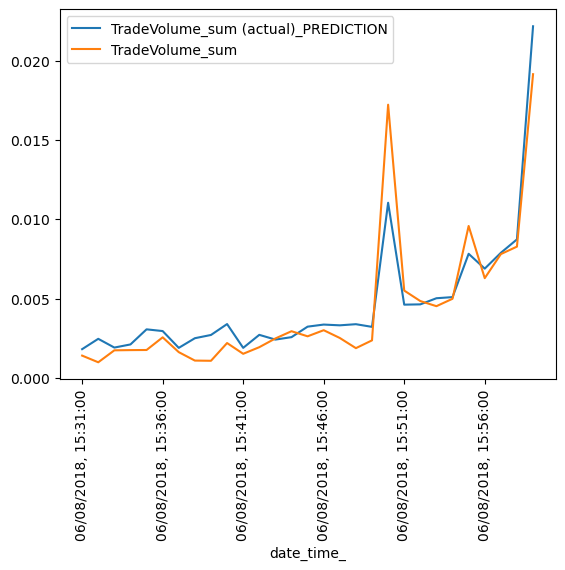

In [34]:
df.plot(x="date_time_", y=["TradeVolume_sum (actual)_PREDICTION", "TradeVolume_sum"], rot=90)